<a href="https://colab.research.google.com/github/ApurbaPaul-NLP/Machine-Learning/blob/main/29_08_2022_Tensorflow_Hub_%26_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).*italicized text*

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms. Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

73728/61306 [====================================] - 0s 0us/step


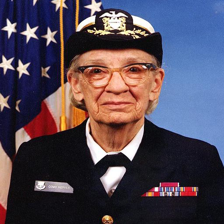

In [3]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 


In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [5]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

24576/10484 [======================================================================] - 0s 0us/step


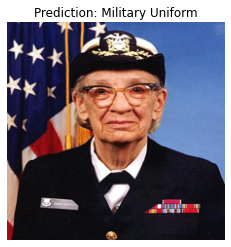

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [8]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete9ZMSRV/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [9]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [10]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tiger cat', 'Egyptian cat', 'Maltese dog', 'tabby', 'toy poodle',
       'kelpie', 'boxer', 'German shepherd', 'Persian cat',
       'English setter', 'schipperke', 'Egyptian cat', 'Rottweiler',
       'Angora', 'tabby', 'Egyptian cat', 'tabby', 'Saint Bernard',
       'Cardigan', 'Siamese cat', 'tiger cat', 'tabby',
       'American Staffordshire terrier', 'dingo', 'Scotch terrier',
       'Egyptian cat', 'tabby', 'shopping basket', 'Siberian husky',
       'Persian cat', 'Egyptian cat', 'toilet tissue'], dtype='<U30')

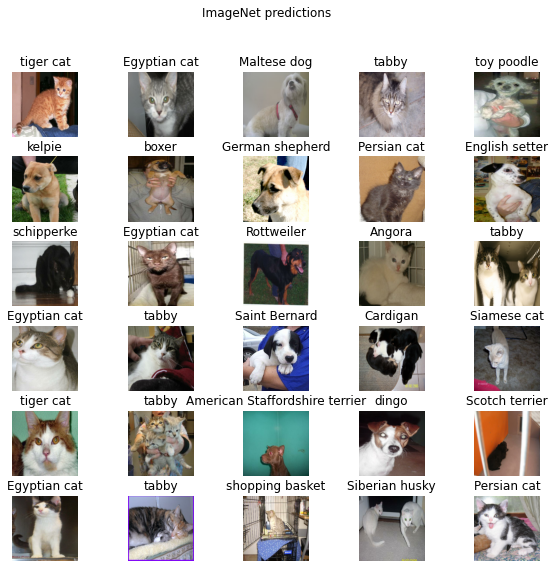

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# **Transfer learning with TensorFlow Hub**

In [14]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [15]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [16]:
feature_extractor.trainable = False

In [17]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 44s 62ms/step - loss: 0.0526 - accuracy: 0.9831 - val_loss: 0.0333 - val_accuracy: 0.9880
Epoch 2/6
582/582 [==============================] - 44s 69ms/step - loss: 0.0307 - accuracy: 0.9893 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 3/6
582/582 [==============================] - 38s 59ms/step - loss: 0.0255 - accuracy: 0.9911 - val_loss: 0.0300 - val_accuracy: 0.9905
Epoch 4/6
582/582 [==============================] - 39s 60ms/step - loss: 0.0215 - accuracy: 0.9924 - val_loss: 0.0305 - val_accuracy: 0.9908
Epoch 5/6
582/582 [==============================] - 38s 59ms/step - loss: 0.0198 - accuracy: 0.9927 - val_loss: 0.0327 - val_accuracy: 0.9895
Epoch 6/6
582/582 [==============================] - 42s 65ms/step - loss: 0.0176 - accuracy: 0.9937 - val_loss: 0.0342 - val_accuracy: 0.9901


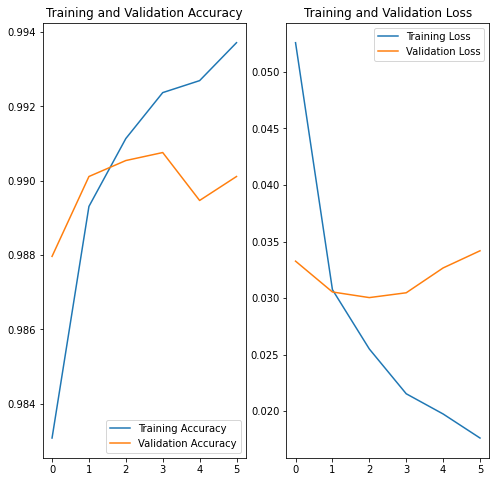

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [21]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat',
       'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog',
       'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat'], dtype='<U3')

In [22]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0]
Predicted labels:  [0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0]


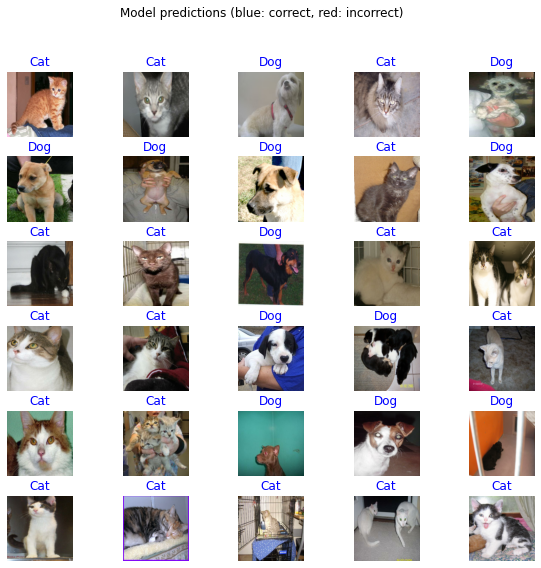

In [23]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")